In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignment1_colab/assignment1'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignment1_colab/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignment1_colab/assignment1


# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline


plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


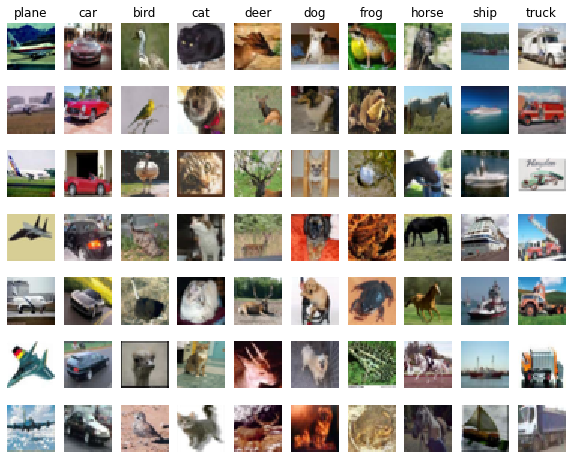

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


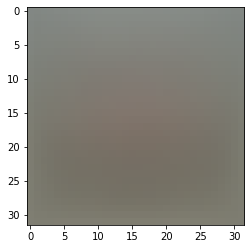

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [8]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.273418


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [9]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)
print("check once again with regularization turned on")
# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 20.335713 analytic: 20.335713, relative error: 2.296805e-11
numerical: -13.953960 analytic: -13.953960, relative error: 3.390262e-11
numerical: 7.049565 analytic: 7.049565, relative error: 5.189991e-11
numerical: 9.320751 analytic: 9.320751, relative error: 4.576199e-11
numerical: 8.467878 analytic: 8.467878, relative error: 1.314099e-11
numerical: 13.327378 analytic: 13.327378, relative error: 2.139731e-11
numerical: -15.206513 analytic: -15.206513, relative error: 1.004643e-11
numerical: -12.488594 analytic: -12.488594, relative error: 2.102368e-11
numerical: -1.586488 analytic: -1.586488, relative error: 1.271508e-10
numerical: 21.378443 analytic: 21.378443, relative error: 3.781639e-12
check once again with regularization turned on
numerical: -15.272810 analytic: -15.272810, relative error: 3.470411e-12
numerical: 10.303279 analytic: 10.303279, relative error: 1.631651e-11
numerical: -7.248288 analytic: -7.248288, relative error: 3.963958e-11
numerical: 5.758493 analytic

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)
print("check once again with regularization turned on")
# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -23.446990 analytic: -23.446990, relative error: 5.390515e-12
numerical: -9.384844 analytic: -9.384844, relative error: 1.806501e-11
numerical: -4.143602 analytic: -4.143602, relative error: 2.175325e-11
numerical: -24.096770 analytic: -24.096770, relative error: 3.648359e-12
numerical: -10.157468 analytic: -10.157468, relative error: 3.041703e-11
numerical: -3.970995 analytic: -3.970995, relative error: 1.128459e-11
numerical: 6.361443 analytic: 6.361443, relative error: 1.103730e-11
numerical: -7.372798 analytic: -7.372798, relative error: 1.990788e-11
numerical: 10.541783 analytic: 10.538927, relative error: 1.354888e-04
numerical: 31.101829 analytic: 31.101829, relative error: 4.379119e-12
check once again with regularization turned on
numerical: -9.273559 analytic: -9.273559, relative error: 3.447376e-11
numerical: -9.234741 analytic: -9.198243, relative error: 1.980032e-03
numerical: 27.499836 analytic: 27.499836, relative error: 3.331238e-12
numerical: -6.994077 analy

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$  
- SVM의 Loss Function은 Hinge Loss로 불리며, max(0, (correct class score와 incorrect score의 차이)+margin)로 정의된다. 이때 뒤 부분의 값을 z로 두자. z > 0이면 score의 차이가 증가하면 선형적으로 loss가 증가하지만 z < 0이면 loss는 0으로 고정된다. 즉, x = 0일경우 기울기가 정의되지 않으므로 analytic diffrentiation이 불가능하다. 따라서 이 부분에서 불일치가 발생하게 된다.


- 간단한 예로, ReLU 활성화 함수는 max(0,z)로 정의되는데, 동일한 이유로 z = 0일 때 gradcheck이 일치하지 않는다. 


- 절대값이 포함된 함수, 예를 들어 y = |x|에서 x = 0일 때 미분가능하지 않으므로, 불일치가 발생한다.


- 하지만 크게 우려할 바는 아니라 생각한다. SVM의 Hinge Loss의 경우 gradcheck의 불일치는 정확히 그 지점, x = 0이라는 지점에서 발생한다. 이는 우리가 연속된 함수에서 수많은 그래디언트 중 하나에 불과할 뿐이기 때문에, 큰 영향을 미치지 않을 것이다. 만약에 오류가 발생한다면, 그 step에서의 그래디언트의 update를 건너뛰면 되는 문제이다. 


- margin을 증가시킬 경우, max(0,z)에서 z가 리턴될 확률이 증가하며 0이 리턴될 확률은 그만큼 줄어든다. 따라서 x = 0에서의 gradcheck가 불일치하는 빈도 또한 줄어들 것이다. 
 


In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.273418e+00 computed in 0.164573s
Vectorized loss: 9.273418e+00 computed in 0.016474s
difference: 0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.159874s
Vectorized loss and gradient: computed in 0.012858s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 782.602248
iteration 100 / 1500: loss 285.497152
iteration 200 / 1500: loss 106.488098
iteration 300 / 1500: loss 42.234415
iteration 400 / 1500: loss 18.877595
iteration 500 / 1500: loss 10.494764
iteration 600 / 1500: loss 7.258456
iteration 700 / 1500: loss 5.486016
iteration 800 / 1500: loss 5.764763
iteration 900 / 1500: loss 5.304806
iteration 1000 / 1500: loss 5.870289
iteration 1100 / 1500: loss 4.960348
iteration 1200 / 1500: loss 5.269582
iteration 1300 / 1500: loss 4.866212
iteration 1400 / 1500: loss 5.727942
That took 11.121887s


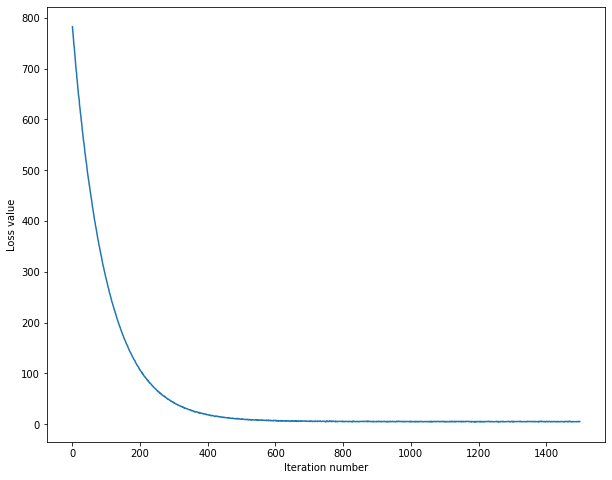

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.367367
validation accuracy: 0.375000


In [28]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-5, 3e-3]
regularization_strengths = [1e4, 2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
  for reg in regularization_strengths:
    
    model = LinearSVM()
    loss_hist = model.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters= 1000,  verbose=True)
    
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    current_y_train_acc = np.mean(y_train_pred == y_train)
    current_y_val_acc = np.mean(y_val_pred == y_val)

    # storing results
    results[(lr, reg)] = (current_y_train_acc, current_y_val_acc)

    if current_y_val_acc > best_val :
      best_val = current_y_val_acc
      best_svm = model

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 323.176924
iteration 100 / 1000: loss 213.373814
iteration 200 / 1000: loss 143.763250
iteration 300 / 1000: loss 96.226660
iteration 400 / 1000: loss 66.127015
iteration 500 / 1000: loss 45.165409
iteration 600 / 1000: loss 32.401090
iteration 700 / 1000: loss 22.882483
iteration 800 / 1000: loss 17.635215
iteration 900 / 1000: loss 12.895104
iteration 0 / 1000: loss 791.121529
iteration 100 / 1000: loss 286.913506
iteration 200 / 1000: loss 107.194620
iteration 300 / 1000: loss 43.527994
iteration 400 / 1000: loss 18.509705
iteration 500 / 1000: loss 10.139251
iteration 600 / 1000: loss 6.506353
iteration 700 / 1000: loss 5.440347
iteration 800 / 1000: loss 5.461384
iteration 900 / 1000: loss 5.447415
iteration 0 / 1000: loss 1550.413647
iteration 100 / 1000: loss 209.932442
iteration 200 / 1000: loss 32.766153
iteration 300 / 1000: loss 9.529994
iteration 400 / 1000: loss 5.745489
iteration 500 / 1000: loss 5.736778
iteration 600 / 1000: loss 5.698595
iterat

/content/drive/My Drive/cs231n/assignment1_colab/assignment1/cs231n/classifiers/linear_svm.py:94: RuntimeWarning: overflow encountered in double_scalars
  loss += reg*np.sum(W*W) # L2 term 추가
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/drive/My Drive/cs231n/assignment1_colab/assignment1/cs231n/classifiers/linear_svm.py:94: RuntimeWarning: overflow encountered in multiply
  loss += reg*np.sum(W*W) # L2 term 추가


iteration 900 / 1000: loss inf
iteration 0 / 1000: loss 1540.293509
iteration 100 / 1000: loss 4369339179502781956758861517749945329883898212602845360635712433681362728529504027206237526382345641509154431969004592562176.000000
iteration 200 / 1000: loss 11282725563591411914320109267885046843639746567711656879961412641613570102486727866332017340387974979431235644311087814705050167721080534033670782350161837518937874200985201386269146668199943283644519568773522338796264346801870600784877428146176.000000
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf


/content/drive/My Drive/cs231n/assignment1_colab/assignment1/cs231n/classifiers/linear_svm.py:90: RuntimeWarning: overflow encountered in subtract
  margins = np.maximum(0, scores-correctlabel_scores + 1)
/content/drive/My Drive/cs231n/assignment1_colab/assignment1/cs231n/classifiers/linear_svm.py:112: RuntimeWarning: overflow encountered in multiply
  dW += reg*2*W


iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
iteration 0 / 1000: loss 326.143095
iteration 100 / 1000: loss inf


/content/drive/My Drive/cs231n/assignment1_colab/assignment1/cs231n/classifiers/linear_svm.py:90: RuntimeWarning: invalid value encountered in subtract
  margins = np.maximum(0, scores-correctlabel_scores + 1)


iteration 200 / 1000: loss nan
iteration 300 / 1000: loss nan
iteration 400 / 1000: loss nan
iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
iteration 0 / 1000: loss 790.404859
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss nan
iteration 300 / 1000: loss nan
iteration 400 / 1000: loss nan
iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
iteration 0 / 1000: loss 1561.569622
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss nan
iteration 300 / 1000: loss nan
iteration 400 / 1000: loss nan
iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.372612 val accuracy: 0.391000
lr 1.000000e-07 reg 2.500000e+04 train a

In [29]:
results

{(1e-07, 10000.0): (0.3726122448979592, 0.391),
 (1e-07, 25000.0): (0.36779591836734693, 0.382),
 (1e-07, 50000.0): (0.3633877551020408, 0.381),
 (5e-05, 10000.0): (0.18993877551020408, 0.18),
 (5e-05, 25000.0): (0.06012244897959184, 0.075),
 (5e-05, 50000.0): (0.10026530612244898, 0.087),
 (0.003, 10000.0): (0.10026530612244898, 0.087),
 (0.003, 25000.0): (0.10026530612244898, 0.087),
 (0.003, 50000.0): (0.10026530612244898, 0.087)}

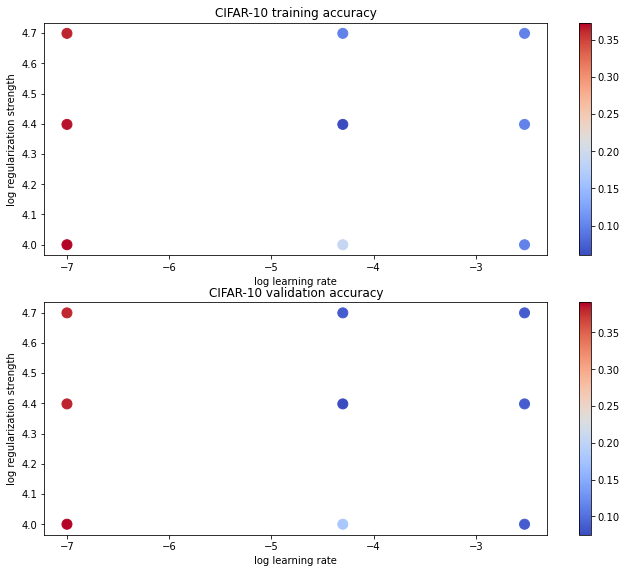

In [30]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [31]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.374000


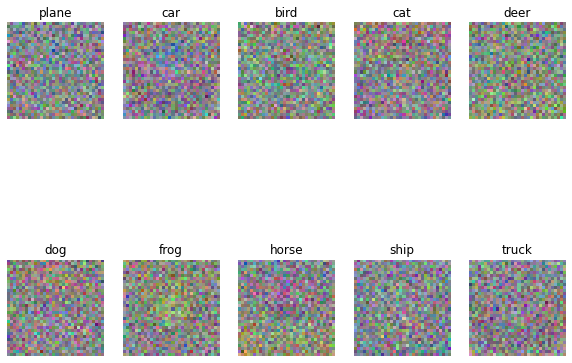

In [33]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ 

이 weight를 시각화한 지도는 똑같은 모자이크처럼 보이긴 하나 자세히 보면 각 클래스마다 pixel색의 구성, 즉 weight의 값 각각이 상당히 다름을 알 수 있다. 

우리는 이러한 가중치를 출력 class의 template를 형성하는 것으로 해석할 수 있는데, 즉 데이터가 많아지고 학습이 진행될수록 이 지도가 input image들을 닮아간다는 것이다. 
